# Data Preprocessing

load_dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care")



- Sample size: 
- For this dataset:

Population Size: 23,911,390

Sample Size: 0.4 % optimal size - 95646

This approach ensures that the sample size is optimal valid for the given confidence level and margin of error.

DatasetDict({
    full: Dataset({
        features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
        num_rows: 23911390
    })
})
Total number of rows: 23911390
New sample size (0.4% of population): 95646
Sampled dataset: Dataset({
    features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
    num_rows: 95646
})


Creating json from Arrow format:   0%|          | 0/96 [00:00<?, ?ba/s]

Sample saved to sampled_data_0_4_percent.jsonl


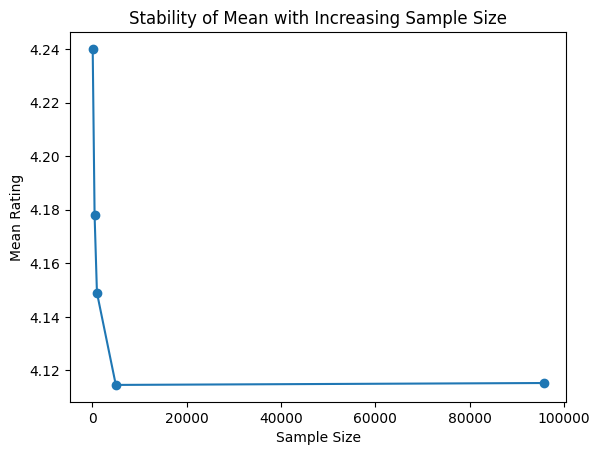

In [ ]:
from datasets import load_dataset
from math import ceil
import matplotlib.pyplot as plt

# Step 1: Load the Dataset
ds = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care")
print(ds)

# Access the 'full' split
split_name = 'full'
population_size = len(ds[split_name])
print(f"Total number of rows: {population_size}")

# Step 2: Calculate 0.4% Increased Sample Size
increase_percentage = 0.004  # 0.4%
additional_sample_size = ceil(population_size * increase_percentage)
new_sample_size = additional_sample_size
print(f"New sample size (0.4% of population): {new_sample_size}")

# Step 3: Randomly Sample the Dataset
sampled_ds = ds[split_name].shuffle(seed=42).select(range(new_sample_size))
print(f"Sampled dataset: {sampled_ds}")

# Step 4: Save the Sample
sampled_ds.to_json("sampled_data_0_4_percent.jsonl")
print("Sample saved to sampled_data_0_4_percent.jsonl")

# Step 5: Evaluate Sample Stability
# Analyze a metric across different sample sizes
sample_sizes = [100, 500, 1000, 5000, new_sample_size]
means = []

for size in sample_sizes:
    sample = ds[split_name].shuffle(seed=42).select(range(size))
    mean_rating = sum(sample['rating']) / len(sample)  # Replace 'rating' with the actual column
    means.append(mean_rating)

# Plot the stability of the mean
plt.plot(sample_sizes, means, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Mean Rating')
plt.title('Stability of Mean with Increasing Sample Size')
plt.show()


# Data Preprocessing

#### Removing punctuation, tokenizing text, and removing stopwords from meta review dataset, you can use nltk or spacy

- Loading meta review dataset: Load the imdb dataset using load_dataset from Hugging Face.
- Tokenization: nltk's word_tokenize splits the text into individual words.
- Stopword Removal: Filter out common words like "the", "is", "and", etc.
- Punctuation Removal: Using string.punctuation to eliminate punctuation tokens.

In [ ]:
from datasets import load_dataset, Features, Value, Sequence
import re
from nltk.corpus import stopwords
import string
import nltk

# Download required NLTK resources
nltk.download('stopwords')

# Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data_0_4_percent.jsonl", split="train")

# Prepare stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

def preprocess_text(text):
    """
    Preprocess a given text: lowercase, remove punctuation, tokenize, and remove stopwords.
    """
    text = text.lower()
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)
    tokens = text.split()
    return [token for token in tokens if token not in stop_words]

# Preprocess and add processed_text column
if "processed_text" not in ds.column_names:
    ds = ds.map(lambda example: {"processed_text": preprocess_text(example['text'])})

# Handle complex columns: Simplify or drop
# Option 1: Drop complex columns
ds = ds.remove_columns(["images"])


# Dynamically generate schema
features = Features({
    col: Value("string") if col != "processed_text" else Sequence(Value("string"))
    for col in ds.column_names
})
ds = ds.cast(features)

# Save the processed dataset
ds.to_json("processed_sampled_data_0_4_percent.jsonl")
print("Processed dataset saved to 'processed_sampled_data_0_4_percent.jsonl'")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Map:   0%|          | 0/95646 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/95646 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/96 [00:00<?, ?ba/s]

Processed dataset saved to 'processed_sampled_data_0_4_percent.jsonl'


- #### Preprocess the first 100 reviews - Get the 20 most common tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


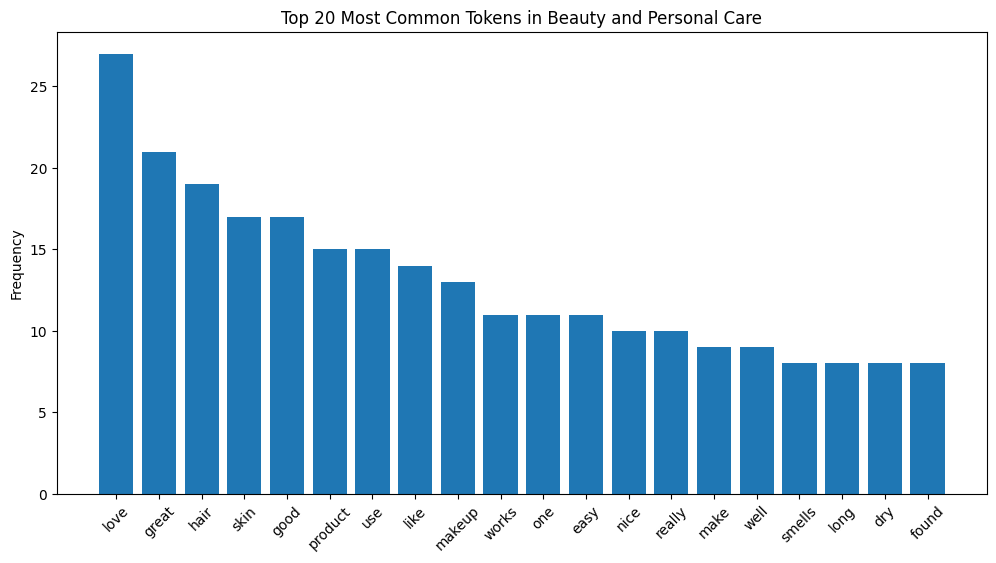

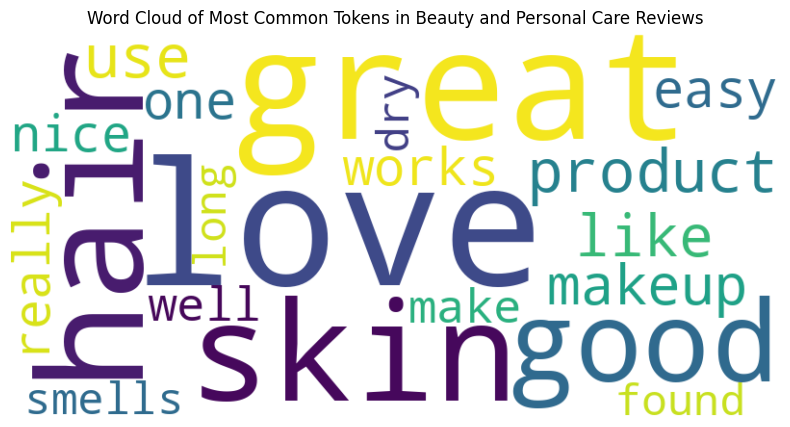

In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk.corpus import stopwords
import re
import string
from collections import Counter
from wordcloud import WordCloud
import nltk

# Download necessary resources
nltk.download('stopwords')

# Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data_0_4_percent.jsonl", split="train")

# Initialize tools
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

# Preprocess text: remove punctuation, stopwords, and tokenize
def preprocess_text(text):
    # Convert to lowercase and remove punctuation
    text = re.sub(f"[{re.escape(punctuation)}]", "", text.lower())
    # Tokenize by splitting
    tokens = text.split()
    # Remove stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    return cleaned_tokens

# Preprocess the first 100 reviews
all_tokens = []
for i in range(100):
    tokens = preprocess_text(ds[i]['text'])
    all_tokens.extend(tokens)

# Get the 20 most common tokens
common_tokens = Counter(all_tokens).most_common(20)
tokens, frequencies = zip(*common_tokens)

# Plot 1: Bar plot of the most common tokens
plt.figure(figsize=(12, 6))
plt.bar(tokens, frequencies)
plt.title('Top 20 Most Common Tokens in Beauty and Personal Care')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

# Plot 2: Word cloud of the most common tokens
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Tokens in Beauty and Personal Care Reviews')
plt.show()